# 1. Setup libraries for Machine Learning 

The first step is to import all the libaries that will be needed to parse and explore the data

In [1]:
# IMPORT LIBRARIES (must be installed via pip)
# ----------------------------------------------------------------------------

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
import numpy as np              # linear algebra
import pandas as pd             # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting
import seaborn as sns           # plotting
import tensorflow as tf         # machine learning
import sys                      # for facets stuff
import base64                   # for facets stuff

# generic_feature_statistics_generator is in the facets directory
sys.path.append('./facets/facets_overview/python')

# ML libraries 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# calculate the feature statistics from the datasets and stringify it for use in facets overview
from generic_feature_statistics_generator import GenericFeatureStatisticsGenerator
from IPython.core.display import display, HTML

# tell jupyter notebook to diplay plotted data inline
%matplotlib inline 

# SET LOCAL VARIABLES
# -----------------------------------------------------------------------------

# define local file for training data with features and labels
csv_file = 'datasets/iris.csv'

# define feature columns for input feature data 
prediction_feature_columns = ['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']

# path to save the model for future training or tensorflow serving
model_path = 'models/temp/iris'

# verify version of tensorflow, should be 1.4+ to use new Estimators features
print('TENSORFLOW VERSION: ' + tf.__version__)


TENSORFLOW VERSION: 1.4.1


# 2. Import Dataset from local CSV file

You will first need to load your raw data from a local CSV file, and you should attempt to output the columns after each step for verification.  

In [2]:
# get full dataset from local CSV file
df = pd.read_csv(csv_file)
df.head()


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


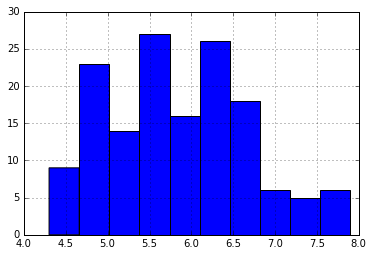

In [3]:
df['SepalLengthCm'].hist()

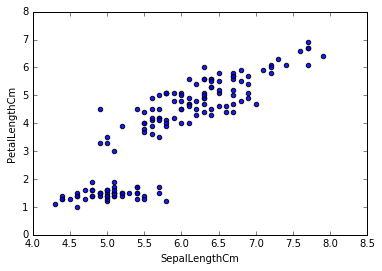

In [4]:
df.plot(kind="scatter", x="SepalLengthCm",y="PetalLengthCm", alpha=0.9)

# 3. Clean up the Dataset

1. eliminate noise in data (remove columns not tied to the label)
2. make values numeric (remove strings with numeric or hash values)
3. randomize order (removes order bias)
4. scale data (scaled according to the data, for training and prediction)

In [5]:
# drop unnecessary 'Id' column from the dataset, doesnt help predict the label
df.drop('Id', inplace=True, axis=1)

In [9]:
# ALWAYS randomize sample
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,6.3,2.8,5.1,1.5,Iris-virginica
1,4.9,3.1,1.5,0.1,Iris-setosa
2,4.4,3.2,1.3,0.2,Iris-setosa
3,5.5,2.5,4.0,1.3,Iris-versicolor
4,7.1,3.0,5.9,2.1,Iris-virginica


### I look for outliers and missing data with a Google tool called: Facets.  You can see the full explanation for how to download and use Facets here:

https://pair-code.github.io/facets/

### Facets - Overview:

In [10]:
# generate statistics for template
gfsg = GenericFeatureStatisticsGenerator()

# load data
proto = gfsg.ProtoFromDataFrames([{'name': 'train', 'table': df}])

# create base64 string for html template
protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")

# Display the facets overview visualization for this data
overview_template = """<link rel="import" href="/nbextensions/facets-dist/facets-jupyter.html" >
        <facets-overview id="overview"></facets-overview>
        <script>
          document.querySelector("#overview").protoInput = "{protostr}";
        </script>"""

# load data into template
overview_html = overview_template.format(protostr=protostr)

# display template
display(HTML(overview_html))

### Facets - Deep Dive:

In [11]:
# convert dataframe to json string to be used by the html template
jsonstr = df.to_json(orient='records')

# Display the Dive visualization for this data
deepdive_template = """<link rel="import" href="/nbextensions/facets-dist/facets-jupyter.html">
        <facets-dive sprite-image-width="32" sprite-image-height="32" id="deepdive" height="600" height="1000"></facets-dive>
        <script>
          document.querySelector("#deepdive").data = {jsonstr};
        </script>"""

# load data into template
deepdive_html = deepdive_template.format(jsonstr=jsonstr)

#display template
display(HTML(deepdive_html))

In [12]:
# label encode the string label: Species
# it should be a numeric value, instead of a string value
# to do: use one-hot encoder instead of label encoder
le = LabelEncoder()
df.Species = le.fit_transform(df.Species)

# show the cleaned dataset
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,6.3,2.8,5.1,1.5,2
1,4.9,3.1,1.5,0.1,0
2,4.4,3.2,1.3,0.2,0
3,5.5,2.5,4.0,1.3,1
4,7.1,3.0,5.9,2.1,2


In [13]:
# set just the label column to y for the train_test_split()
# *** need to shuffle the dataset first?
data_label = df.Species
data_label.head()

0    2
1    0
2    0
3    1
4    2
Name: Species, dtype: int64

In [14]:
# remove the species column so that you can scale the rest of the values
# the values are already stored in y variable
# *** convert this to X values here, for clarity?
data_features = df.drop('Species', inplace=False, axis=1)
data_features.head()


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,6.3,2.8,5.1,1.5
1,4.9,3.1,1.5,0.1
2,4.4,3.2,1.3,0.2
3,5.5,2.5,4.0,1.3
4,7.1,3.0,5.9,2.1


In [15]:
# scale data for better results
# so that columns with larger values dont get weighed more
# example: age change of 40 years (significant) vs income change of $40 (not significant)

sc = StandardScaler(copy=True, with_mean=True, with_std=True)
scaled_features = pd.DataFrame(sc.fit_transform(data_features), columns=[data_features.columns], index=data_features.index)

# show scaled X values 
scaled_features.head() 
# THIS IS A DATAFRAME

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,0.553333,-0.587764,0.762759,0.396172
1,-1.143017,0.106445,-1.284407,-1.444450
2,-1.748856,0.337848,-1.398138,-1.312977
3,-0.416010,-1.281972,0.137236,0.133226
4,1.522676,-0.124958,1.217684,1.185010


In [16]:
# show labels (y values in equasion)
data_label.head()
# THIS IS A SERIES


0    2
1    0
2    0
3    1
4    2
Name: Species, dtype: int64

In [17]:
# do a 70/30 split of the data into a train_x and train_y (70% for training) 
# and a test_x and test_y (30% for validation) 
# X is a DATAFRAME of scaled features
# y is a SERIES of labels
train_x, test_x, train_y, test_y = train_test_split(scaled_features, data_label, test_size=0.30, random_state=101)
 

In [18]:
test_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45 entries, 33 to 66
Data columns (total 4 columns):
SepalLengthCm    45 non-null float64
SepalWidthCm     45 non-null float64
PetalLengthCm    45 non-null float64
PetalWidthCm     45 non-null float64
dtypes: float64(4)
memory usage: 1.8 KB


# 4. Create Feature Columns List for Classifier

In [19]:
# Feature columns describe how to use the input.
# you need to define the name and type for each column of your training data
my_feature_columns = []

# numeric coulmns
my_feature_columns.append(tf.feature_column.numeric_column(key='SepalLengthCm'));
my_feature_columns.append(tf.feature_column.numeric_column(key='SepalWidthCm'));
my_feature_columns.append(tf.feature_column.numeric_column(key='PetalLengthCm'));
my_feature_columns.append(tf.feature_column.numeric_column(key='PetalWidthCm'));   

# other column types
# hashed strings or categorical features
# example:
# state = tf.feature_column.categorical_column_with_hash_bucket('state',100) 
# pick the right size for your data

    

# 5. Create Classifier from Feature Column list

In [20]:
# Build 2 hidden layer DNN with 10, 10 units respectively
# uses feature column types defined in the previous step
classifier = tf.estimator.DNNClassifier(
    # feature columns defined in the prev step
    feature_columns=my_feature_columns,
    # Two hidden layers of 10 nodes each.
    hidden_units=[10, 10, 10],
    # The model must choose between 3 classes.
    n_classes=data_label.nunique(),
    # save the model to a folder when run, reuse the same way
    model_dir=model_path
)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1219a19d0>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': 'models/temp/iris', '_save_summary_steps': 100}


In [21]:
# setup the train input function using the train_x and train_y datasource
train_input_fn = tf.estimator.inputs.pandas_input_fn(train_x, y=train_y, num_epochs=5000, shuffle=True)


# 6. Train Classifier

In [22]:
# this is where training actually occurs, this will be a long running process on large datasets
classifier.train(input_fn=train_input_fn)


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into models/temp/iris/model.ckpt.
INFO:tensorflow:loss = 127.135925, step = 1
INFO:tensorflow:global_step/sec: 389.616
INFO:tensorflow:loss = 6.9050293, step = 101 (0.261 sec)
INFO:tensorflow:global_step/sec: 384.406
INFO:tensorflow:loss = 3.0640566, step = 201 (0.259 sec)
INFO:tensorflow:global_step/sec: 431.967
INFO:tensorflow:loss = 2.6498284, step = 301 (0.232 sec)
INFO:tensorflow:global_step/sec: 416.62
INFO:tensorflow:loss = 3.937459, step = 401 (0.240 sec)
INFO:tensorflow:global_step/sec: 424.975
INFO:tensorflow:loss = 2.3510833, step = 501 (0.235 sec)
INFO:tensorflow:global_step/sec: 411.938
INFO:tensorflow:loss = 1.4174278, step = 601 (0.243 sec)
INFO:tensorflow:global_step/sec: 417.052
INFO:tensorflow:loss = 0.53422797, step = 701 (0.240 sec)
INFO:tensorflow:global_step/sec: 428.26
INFO:tensorflow:loss = 1.5141351, step = 801 (0.235 sec)
INFO:tensorflow:global_step/sec: 410.533
INFO:tensorflo

# 7. Test classifier with the 30% split data

In [23]:
# validate the model using the x_test values to get a prediction for each one
# then you can compare the predicted values against the known values in test_y
# which will give you an accuracy score in percentage
test_input_fn = tf.estimator.inputs.pandas_input_fn(test_x, num_epochs=1, shuffle=False)


In [24]:
test_result = list(classifier.predict(input_fn=test_input_fn))

print(test_result)

INFO:tensorflow:Restoring parameters from models/temp/iris/model.ckpt-4102
[{'probabilities': array([9.9999988e-01, 9.1881631e-08, 2.7562536e-33], dtype=float32), 'logits': array([ 16.76355  ,   0.5607845, -58.207882 ], dtype=float32), 'classes': array(['0'], dtype=object), 'class_ids': array([0])}, {'probabilities': array([7.3880653e-07, 9.9999917e-01, 1.2444411e-07], dtype=float32), 'logits': array([-5.60056  ,  8.517669 , -7.3817396], dtype=float32), 'classes': array(['1'], dtype=object), 'class_ids': array([1])}, {'probabilities': array([7.3989389e-07, 9.9999928e-01, 2.5323835e-10], dtype=float32), 'logits': array([ -4.531504,   9.585255, -12.511435], dtype=float32), 'classes': array(['1'], dtype=object), 'class_ids': array([1])}, {'probabilities': array([9.999999e-01, 7.674641e-08, 6.574133e-33], dtype=float32), 'logits': array([ 16.69859   ,   0.31582946, -57.403576  ], dtype=float32), 'classes': array(['0'], dtype=object), 'class_ids': array([0])}, {'probabilities': array([1.042

In [25]:
# build an array with just the predicted species (label encoded values) 
# filtering out all other prediction response data
predicted_y = []
for each in test_result:
    predicted_y.append(each['class_ids'][0])

In [26]:
# compare the predicted scores on the test data against the actual test_y values
# with both a confusion matrix and an accuracy score
print('OVERALL ACCURACY:')
print(accuracy_score(test_y, predicted_y))

print('')

print('CONFUSION MATRIX:')
print(confusion_matrix(test_y, predicted_y))


OVERALL ACCURACY:
0.9777777777777777

CONFUSION MATRIX:
[[20  0  0]
 [ 0 15  1]
 [ 0  0  9]]


# 8. Predict with new data records 

In [27]:
# test using single records (real world values)
# one Iris-setosa, one Iris-versicolor
new_records = pd.DataFrame([
    [5.1, 3.5, 1.4, 0.2],  # first value to predict
    [5.7, 2.8, 4.1, 1.3]], # second value to predict
    columns=prediction_feature_columns)
 
# these values must be scaled, to match what is used in the model
scaled_new_records = pd.DataFrame(sc.transform(new_records), columns=[new_records.columns], index=new_records.index)

#SepalLengthCm, SepalWidthCm, PetalLengthCm, PetalWidthCm
#-1.870024, -0.124958, -1.511870, -1.444450 : 0
# 1.522676, -0.124958, 1.217684, 1.185010 : 1


In [28]:
# predict using the model to get a prediction for each item passed
prediction_input_fn = tf.estimator.inputs.pandas_input_fn(scaled_new_records, num_epochs=1, shuffle=False)

In [29]:
prediction_result = list(classifier.predict(input_fn=prediction_input_fn))

prediction_result

INFO:tensorflow:Restoring parameters from models/temp/iris/model.ckpt-4102


[{'class_ids': array([0]),
  'classes': array(['0'], dtype=object),
  'logits': array([ 13.923073  ,   0.15754622, -47.713924  ], dtype=float32),
  'probabilities': array([9.9999893e-01, 1.0512529e-06, 1.7036948e-27], dtype=float32)},
 {'class_ids': array([1]),
  'classes': array(['1'], dtype=object),
  'logits': array([-5.4769983,  9.47805  , -8.857482 ], dtype=float32),
  'probabilities': array([3.1996672e-07, 9.9999964e-01, 1.0888774e-08], dtype=float32)}]

# 9. Decode new predictions

In [30]:
# for each of the results
i = 0
for each in prediction_result:
    # print the values used in the prediction
    print(new_records.iloc[[i]])
    
    # print the transformed label-encoded value
    print('*** PREDICTION: ' + str(each['class_ids'][0]) + ' (Label Decoded: ' + str(le.inverse_transform(each['class_ids'][0]))+ ')')
    print('')
    
    # go to next row
    i = i + 1
    
#-1.870024, -0.124958, -1.511870, -1.444450 : 0
# 1.522676, -0.124958, 1.217684, 1.185010 : 1

   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
0            5.1           3.5            1.4           0.2
*** PREDICTION: 0 (Label Decoded: Iris-setosa)

   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
1            5.7           2.8            4.1           1.3
*** PREDICTION: 1 (Label Decoded: Iris-versicolor)



/Users/jameswolf/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jameswolf/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# 10. Save Model for Tensorflow Serving

In [31]:
export_dir="serving/models/iris/"

feature_spec = tf.feature_column.make_parse_example_spec(my_feature_columns)

input_receiver_fn = tf.estimator.export.build_parsing_serving_input_receiver_fn(feature_spec)

classifier.export_savedmodel(export_dir, input_receiver_fn, as_text=False) 

INFO:tensorflow:Restoring parameters from models/temp/iris/model.ckpt-4102
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: serving/models/iris/temp-1523851403/saved_model.pb


'serving/models/iris/1523851403'

# 11. Make predictions from the saved DNNClassifier model

https://www.kaggle.com/jeffcarp/example-save-and-load-a-tensorflow-model

In [32]:
# this should load the model from the last saved in the model_dir
# so everything it needs should be included below

# input column names
columns_names = ['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']

# where the model was last saved 
model_path = 'models/temp/iris' 

# define columns in model using the column_names list
# Feature columns describe how to use the input.
# you need to define the name and type for each column of your training data
hardcoded_feature_columns = []

# numeric coulmns
hardcoded_feature_columns.append(tf.feature_column.numeric_column(key='SepalLengthCm'));
hardcoded_feature_columns.append(tf.feature_column.numeric_column(key='SepalWidthCm'));
hardcoded_feature_columns.append(tf.feature_column.numeric_column(key='PetalLengthCm'));
hardcoded_feature_columns.append(tf.feature_column.numeric_column(key='PetalWidthCm'));   

#hardcoded_feature_columns = []
#for key in columns_names:
#    hardcoded_feature_columns.append(tf.feature_column.numeric_column(key=key))
#    print(key)

# create a classifier using the defined columns and the pre-defined model
saved_estimator = tf.estimator.DNNClassifier(
    # feature column array of tf.feature_column types, defined in the prev step
    feature_columns=hardcoded_feature_columns,
    # Two hidden layers of 10 nodes each.
    hidden_units=[10, 10, 10],
    # The model must choose between 3 classes.
    n_classes=3,
    # use saved model from folder
    model_dir=model_path
)

# test using single records (2 real world values)
# one Iris-setosa, one Iris-versicolor
records_to_predict = pd.DataFrame([
    [5.1, 3.5, 1.4, 0.2], # first records features
    [5.7, 2.8, 4.1, 1.3]],# second record features
    columns=columns_names)# defined column names
 
# these values must be scaled, to match what is used in the model
scaled_records_to_predict = pd.DataFrame(sc.transform(records_to_predict), columns=[records_to_predict.columns], index=records_to_predict.index)

# predict using the model to get a prediction for each item passed
saved_prediction_input_fn = tf.estimator.inputs.pandas_input_fn(scaled_records_to_predict, num_epochs=1, shuffle=False)

# make predictions and store as a list
saved_prediction_result = list(saved_estimator.predict(input_fn=saved_prediction_input_fn))

# output prediction values
saved_prediction_result

#SepalLengthCm, SepalWidthCm, PetalLengthCm, PetalWidthCm
#-1.870024, -0.124958, -1.511870, -1.444450 : 0
# 1.522676, -0.124958, 1.217684, 1.185010 : 1
#estimator_from_file = load_estimator_model('models/iris/1520662093')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x123a35a50>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': 'models/temp/iris', '_save_summary_steps': 100}
INFO:tensorflow:Restoring parameters from models/temp/iris/model.ckpt-4102


[{'class_ids': array([0]),
  'classes': array(['0'], dtype=object),
  'logits': array([ 13.923073  ,   0.15754622, -47.713924  ], dtype=float32),
  'probabilities': array([9.9999893e-01, 1.0512529e-06, 1.7036948e-27], dtype=float32)},
 {'class_ids': array([1]),
  'classes': array(['1'], dtype=object),
  'logits': array([-5.4769983,  9.47805  , -8.857482 ], dtype=float32),
  'probabilities': array([3.1996672e-07, 9.9999964e-01, 1.0888774e-08], dtype=float32)}]

# END

Just testing features and note below this line, not part of main execution

In [ ]:
df.head()